In [1]:
from scipy.integrate import odeint
import numpy as np
import theano 
from theano import *
from util.plot_pairwise import pairwise
import matplotlib.pyplot as plt
%matplotlib inline
THEANO_FLAGS='optimizer=fast_compile'


## Lotka-Volterra predator prey model

 The Lotka Volterra model depicts an ecological system that is used to describe the interaction between a predator and prey species. This ODE given by
 \begin{aligned}
 	\frac{d x}{dt} &=\alpha x -\beta xy \\
 	\frac{d y}{dt} &=-\gamma y + \delta xy,
 \end{aligned}
 shows limit cycle behaviour and has been often used for benchmarking Bayesian inference algorithms. $\boldsymbol{\theta}=(\alpha,\beta,\gamma,\delta, x(0),y(0))$ is the set of unknown parameters that we wish to infer from experimental observations of the state vector $X(t)=(x(t),y(t))$ comprising the concentrations of the predator and the prey species respectively. $x(0), y(0)$ are the initial values of the states needed to solve the ODE, which are also unknown quantities. 
 
 Let me first write down the code to solve this ODE using the `scipy`'s `odeint`. The `jac_x` and `jac_p` are the state and parameter Jacobians. One "gotcha" is that the initial value of a state's sensitivity to an unknow initial value parameter is 1. Example, $\frac{d  [-\alpha x -\beta xy]}{d x(t_0)}=1$.

In [2]:
n_states = 2
n_odeparams = 4
n_ivs = 2

class LotkaVolterraModel(object):  
    def __init__(self, y0=None):
        if y0 is None:
            self._y0 = np.array(n_ivs, dtype=float)
        else:
            self._y0 = np.array(y0, dtype=float)
    def solve(self, parameters, times):
        return self._solve(parameters, times, False)
    def solve_with_sensitivities(self, parameters, times):
        return self._solve(parameters, times, True)
    def _solve(self, parameters, times, sensitivities): 
        alpha, beta, gamma, delta, Xt0, Yt0 = [float(x) for x in parameters]
        def r(y, t, p):
            X, Y = y
            dX_dt = alpha*X - beta*X*Y
            dY_dt = -gamma*Y + delta*X*Y
            return dX_dt, dY_dt
        if sensitivities:
            def jac_x(y):
                X, Y = y
                ret = np.empty((n_states, n_states))
                ret[0, 0] = alpha -beta*Y
                ret[0, 1] = - beta*X
                ret[1, 0] = delta*Y
                ret[1, 1] = -gamma + delta*X
                return ret
            def jac_p(y):
                X, Y = y
                ret = np.empty((n_states, n_odeparams + n_ivs))
                ret[0, 0] = X      # \frac{d  [\alpha x - \beta xy]}{d \alpha}, and so on...
                ret[0, 1] = - X*Y
                ret[0, 2] = 0
                ret[0, 3] = 0
                ret[0, 4] = 0
                ret[0, 5] = 0
                
                ret[1, 0] = 0      
                ret[1, 1] = 0      
                ret[1, 2] = -Y
                ret[1, 3] = X*Y 
                ret[1, 4] = 0      # \frac{d  [-\gamma y + \delta xy]}{d x(t_0)}
                ret[1, 5] = 0
                return ret
            def rhs(y_and_dydp, t, p):
                y = y_and_dydp[0:n_states]
                dydp = y_and_dydp[n_states:].reshape((n_states, n_odeparams + n_ivs))
                dydt = r(y, t, p)
                d_dydp_dt = np.matmul(jac_x(y), dydp) + jac_p(y)
                return np.concatenate((dydt, d_dydp_dt.reshape(-1)))
            y0 = np.zeros(14)   
            y0[6] = 1.            #\frac{d  [X]}{d Xt0} at t==0, and same below for Y
            y0[13] = 1.         
            y0[0:n_states] = [Xt0, Yt0]
            result = odeint(rhs, y0, times, (parameters,),rtol=1e-6,atol=1e-5)
            x = result[:, 0:n_states]
            dx_dp = result[:, n_states:].reshape((len(times), n_states, n_odeparams + n_ivs))
            return x, dx_dp
        else:
            x = odeint(r, [Xt0, Yt0], times, (parameters,),rtol=1e-6,atol=1e-5)
            return x        
ode_model = LotkaVolterraModel()

## Custom ODE Op

Here I would define the custom `op` in Theano using the VJP with forward sensitivity method. The actual VJP is carried out in `numpy`. The class `ODEop` below evaluates forward pass, whereas the class `ODEGradop` is used for the backward pass. We have repeated this theme for all RMAD software (`PyTorch`, `TensorFLow` etc) for forward sensitivity based VJP. Note how this opens up the possibility to embed any ODE solver (with a `Python` wrapper). Hopefully, this embedding appraoch would save a lot of time and energy by refraining from implementing legacy solver and modelling softwares in RMAD software from scratch. For example we could repeat this entire excercise by using the `Python` wrapper of the famous `Julia`'s `DifferentialEquations.jl` [package](https://github.com/JuliaDiffEq/diffeqpy). Just embed whatever you like! 

Unlike `Pyro` or `TensorFlow Probability` there is no way to vectorise the MC ELBO evluation in `PyMC3`. At least we are not aware of that!


In [3]:
class ODEGradop(theano.Op):
    def __init__(self, numpy_vjp):
        self._numpy_vjp = numpy_vjp

    def make_node(self, x, g):
        x = theano.tensor.as_tensor_variable(x)
        g = theano.tensor.as_tensor_variable(g)
        node = theano.Apply(self, [x, g], [g.type()])
        return node

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]

        g = inputs_storage[1]
        out = output_storage[0]
        out[0] = np.asarray(self._numpy_vjp(x, g))

        
class ODEop(theano.Op):

    def __init__(self, state, numpy_vjp):
        self._state = state
        self._numpy_vjp = numpy_vjp

    def make_node(self, x):
        x = theano.tensor.as_tensor_variable(x)

        return theano.Apply(self, [x], [x.type()])

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]
        out = output_storage[0]
        
        out[0] = np.asarray(self._state(x))    # get the numerical solution of ODE states

    def grad(self, inputs, output_grads):
        x = inputs[0]
        g = output_grads[0]
        op = self

        grad_op = ODEGradop(self._numpy_vjp)   # get the numerical VSP
        grad_op_apply = grad_op(x, g)
        
        return [grad_op_apply]

I have written a wraper code below that works kind of like a `ctx` in PyTorch (autograd `Function`), to evaluate the states and sensitivity in the forward call only. 

In [4]:
class solveCached(object):
    def __init__(self, times, n_params, n_outputs):
      
        self._times = times
        self._n_params = n_params
        self._n_outputs = n_outputs
        self._cachedParam = np.zeros(n_params)
        self._cachedSens = np.zeros((len(times), n_outputs, n_params))
        self._cachedState = np.zeros((len(times),n_outputs))
        
    def __call__(self, x):
        
        if np.all(x==self._cachedParam):
            state, sens = self._cachedState, self._cachedSens
            
        else:
            state, sens = ode_model.solve_with_sensitivities(x, times)
        
        return state, sens
times = np.arange(0, 21) # number of measurement points (see below)   
cached_solver=solveCached(times, n_odeparams + n_ivs, n_states)

### The ODE state & VJP evaluation with Forward sensitivity

Most ODE systems of practical interest will have multiple states and thus the output of the solver, which I denote as $\boldsymbol{X}$, for a system with $K$ states solved on $T$ time points, would be a $T \times K$-dimensional matrix. For the Lotka-Volterra model the columns of this matrix represent the time evolution of the individual species concentrations. I flatten this matrix to a $KT$-dimensional vector $vec(\boldsymbol{X})$, and also rearrange the sensitivities accordingly to obtain the desired vector-matrix product. 

In [5]:
def state(x):
    State, Sens = cached_solver(np.array(x,dtype=np.float64))
    cached_solver._cachedState, cached_solver._cachedSens, cached_solver._cachedParam = State, Sens, x
    return State.reshape((n_states*len(State),))

def numpy_vjp(x, g):    
    numpy_sens = cached_solver(np.array(x,dtype=np.float64))[1].reshape((n_states*len(times),len(x)))
    return numpy_sens.T.dot(g)

## The  Hudson's Bay Company data

The Lotka-Volterra predator prey model has been used previously to successfully explain the dynamics of natural populations of predators and prey, such as the lynx and snowshoe hare data of the Hudson's Bay Company. 

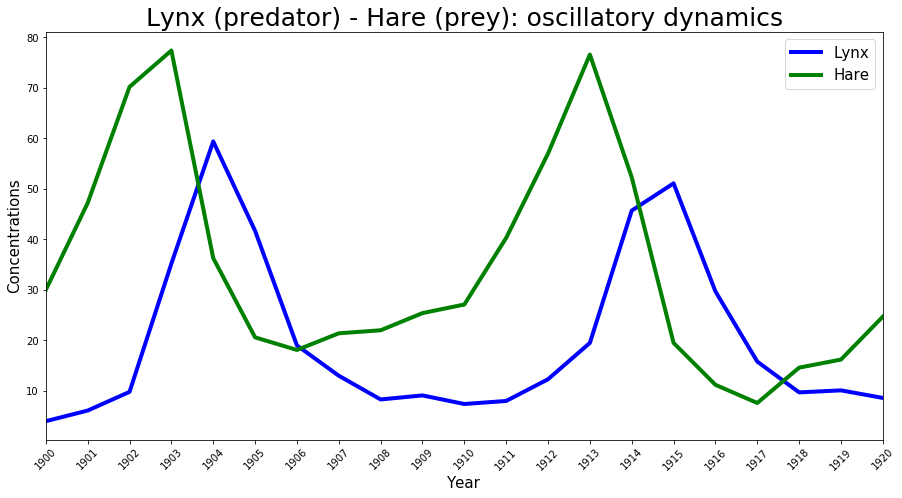

In [6]:
Year = np.arange(1900,1921,1)
Lynx = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
                8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6])
Hare = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4, 
                 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])
plt.figure(figsize=(15, 7.5))
plt.plot(Year,Lynx,color='b', lw=4, label='Lynx')
plt.plot(Year,Hare,color='g', lw=4, label='Hare')
plt.legend(fontsize=15)
plt.xlim([1900,1920])
plt.xlabel('Year', fontsize=15)
plt.ylabel('Concentrations', fontsize=15)
plt.xticks(Year,rotation=45)
plt.title('Lynx (predator) - Hare (prey): oscillatory dynamics', fontsize=25);


# The probablistic model

I have now got all the ingredients needed in order to define the probabilistic model in `PyMC3`. As I have mentioned previously I will set up the probabilistic model with the exact same likelihood and priors used in the STAN example. The observed data is defined as follows:

$$\log (\boldsymbol{Y(t)}) = \log (\boldsymbol{X(t)}) + \eta(t),$$ 

where $\eta(t)$ is assumed to be zero mean i.i.d Gaussian noise with an unknown standard deviation $\sigma$, that needs to be estimated. The above multiplicative (on the natural scale) noise model encodes a lognormal distribution as the likelihood:

$$\boldsymbol{Y(t)} = \mathcal{L}\mathcal{N}(\log (\boldsymbol{X(t)}), \sigma^2).$$

The following priors are then placed on the parameters:


\begin{aligned}
X(0), Y(0) &\sim  \mathcal{L}\mathcal{N}(\log(10),1),\\
\alpha, \gamma &\sim \operatorname{Gamma}(\mu=0.5, \sigma=1),\\
\beta, \delta &\sim \operatorname{Beta}{N}(\mu=0.1, \sigma=.1),\\
\sigma &\sim \mathcal{L}\mathcal{N}(-1,1).
\end{aligned}

The above probabilistic model is defined in PyMC3 below. Note that the flattened state vector is reshaped to match the data dimensionality.

Now simply call `ADVI` with a `FullRank` Normal approximation:

We have removed the outputs and messages from the following code block to maintain anonymity

In [ ]:
import pymc3 as pm
theano.config.exception_verbosity= 'high'
theano.config.floatX = 'float64'
theano.config.compute_test_value = 'ignore'

# Define the data matrix
Y = np.vstack((Hare,Lynx)).T

# Now instantiate the theano custom ODE op
my_ODEop = ODEop(state,numpy_vjp)


# The probabilistic model
with pm.Model() as LV_model:

    # Priors for unknown model parameters
    alpha =  pm.Gamma('alpha', mu=0.5,sd=1)
    beta =  pm.Beta('beta', mu=0.1,sigma=0.1)
    gamma =  pm.Gamma('gamma', mu=0.5,sd=1)
    delta = pm.Beta('delta', mu=0.1,sigma=0.1)
    
    xt0 = pm.Lognormal('xto', mu=np.log(10), sd=1)
    yt0 = pm.Lognormal('yto', mu=np.log(10), sd=1)
    sigma = pm.HalfNormal('sigma', sd=1, shape=2)

    all_params = pm.math.stack([alpha,beta,gamma,delta,xt0,yt0],axis=0)
    ode_sol = my_ODEop(all_params)
    mu = ode_sol.reshape(Y.shape)
    

    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(mu), sd=sigma, observed=Y)
    

    advi=pm.FullRankADVI()
    tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval, std=advi.approx.std.eval ) 
    rho_approx = advi.approx.params[0] 
    mu_approx = advi.approx.params[1] 
    rho_approx.set_value(0.1*np.ones(rho_approx.eval().shape))     

    q_dist = advi.fit(5000,obj_n_mc=5,
                    obj_optimizer=pm.adam(learning_rate=0.01),callbacks=[tracker]);

We may have used `obj_n_mc` =1, to further speed up. But in that case one should use more iterations. See PyMC3 docs for using the tracker above to visualise the ELBO as well as checking convergence of the parameters. That way we could avoid using fixed number of iterations.

In [ ]:
trace_vb = q_dist.sample(1000)
vb_params_ode = np.array([trace_vb.get_values('alpha'),trace_vb.get_values('beta'),trace_vb.get_values('gamma'),
                     trace_vb.get_values('delta'),trace_vb.get_values('xto'),trace_vb.get_values('yto')]).T
vb_params_sd = np.array(trace_vb.get_values('sigma'))
vb_params = np.concatenate((vb_params_ode,vb_params_sd),axis=1)

### We have provided a utility function `pairwise` for visualising the joint densities as heatmaps

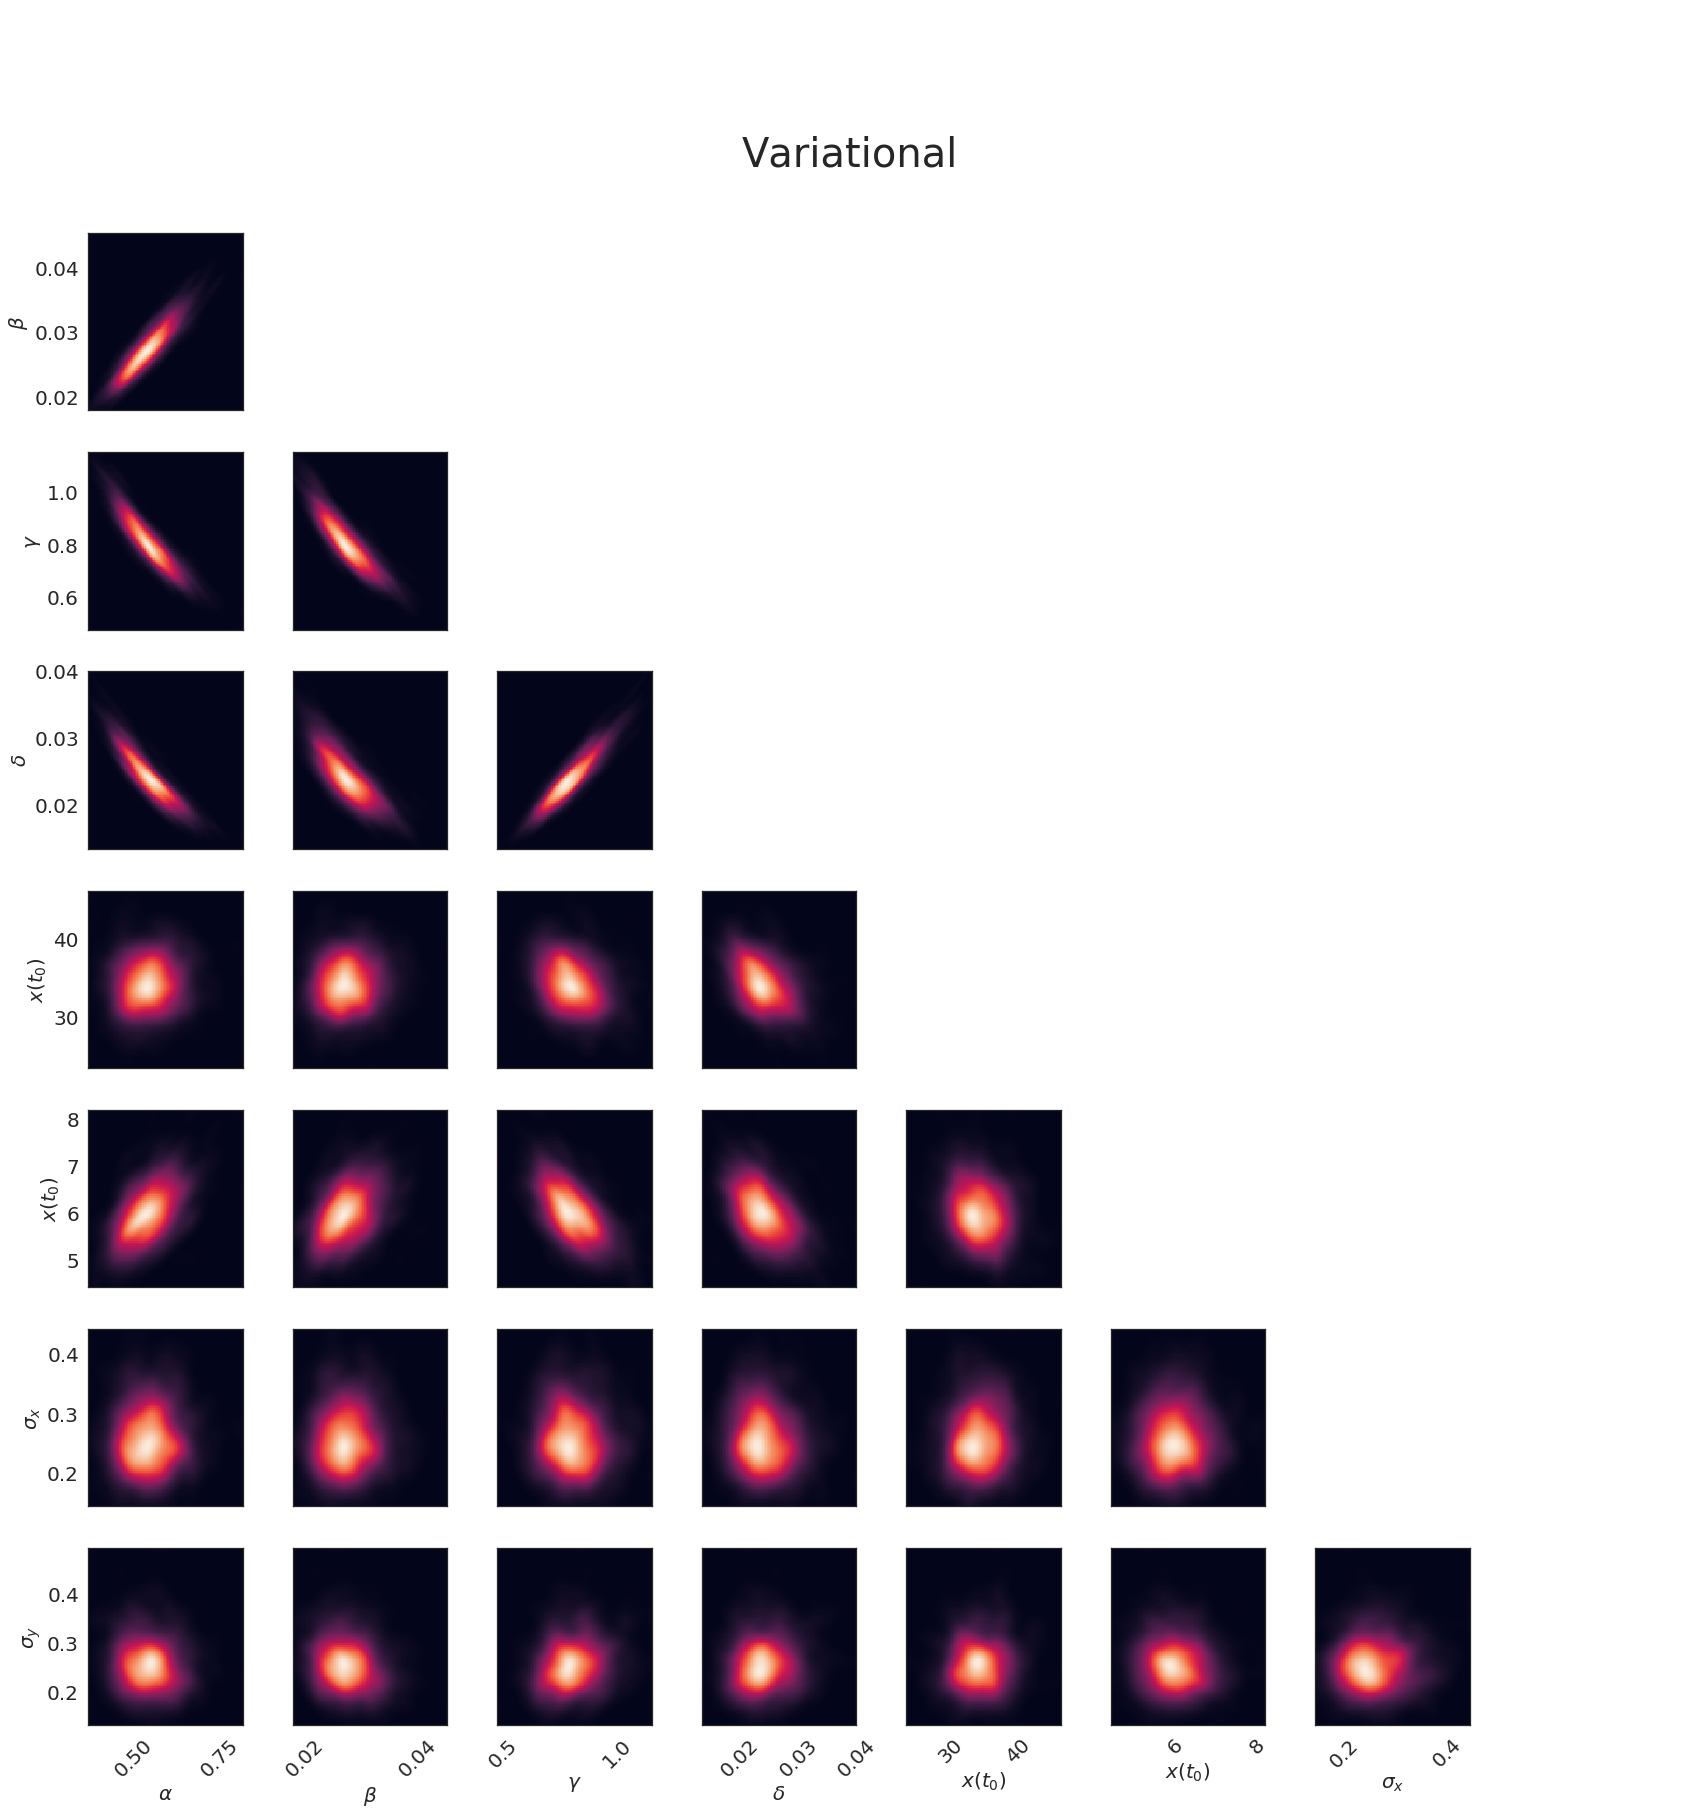

In [9]:
param_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$", 
               r"$x(t_0)$", r"$x(t_0)$",r"$\sigma_x$",r"$\sigma_y$"]

pairwise(vb_params, 'Variational', param_names);

# MCMC baseline

Of course we need the MCMC results to compare our vb results against:
Again outputs/messages removed for anonymity

In [ ]:
with LV_model:
    trace = pm.sample(1500, tune=1000,init='adapt_diag');

In [11]:
mc_params_ode = np.array([trace.get_values('alpha'),trace.get_values('beta'),trace.get_values('gamma'),
                     trace.get_values('delta'),trace.get_values('xto'),trace.get_values('yto')]).T
mc_params_sd = np.array(trace.get_values('sigma'))
mc_params = np.concatenate((mc_params_ode,mc_params_sd),axis=1)[::6,:]## <---Thining

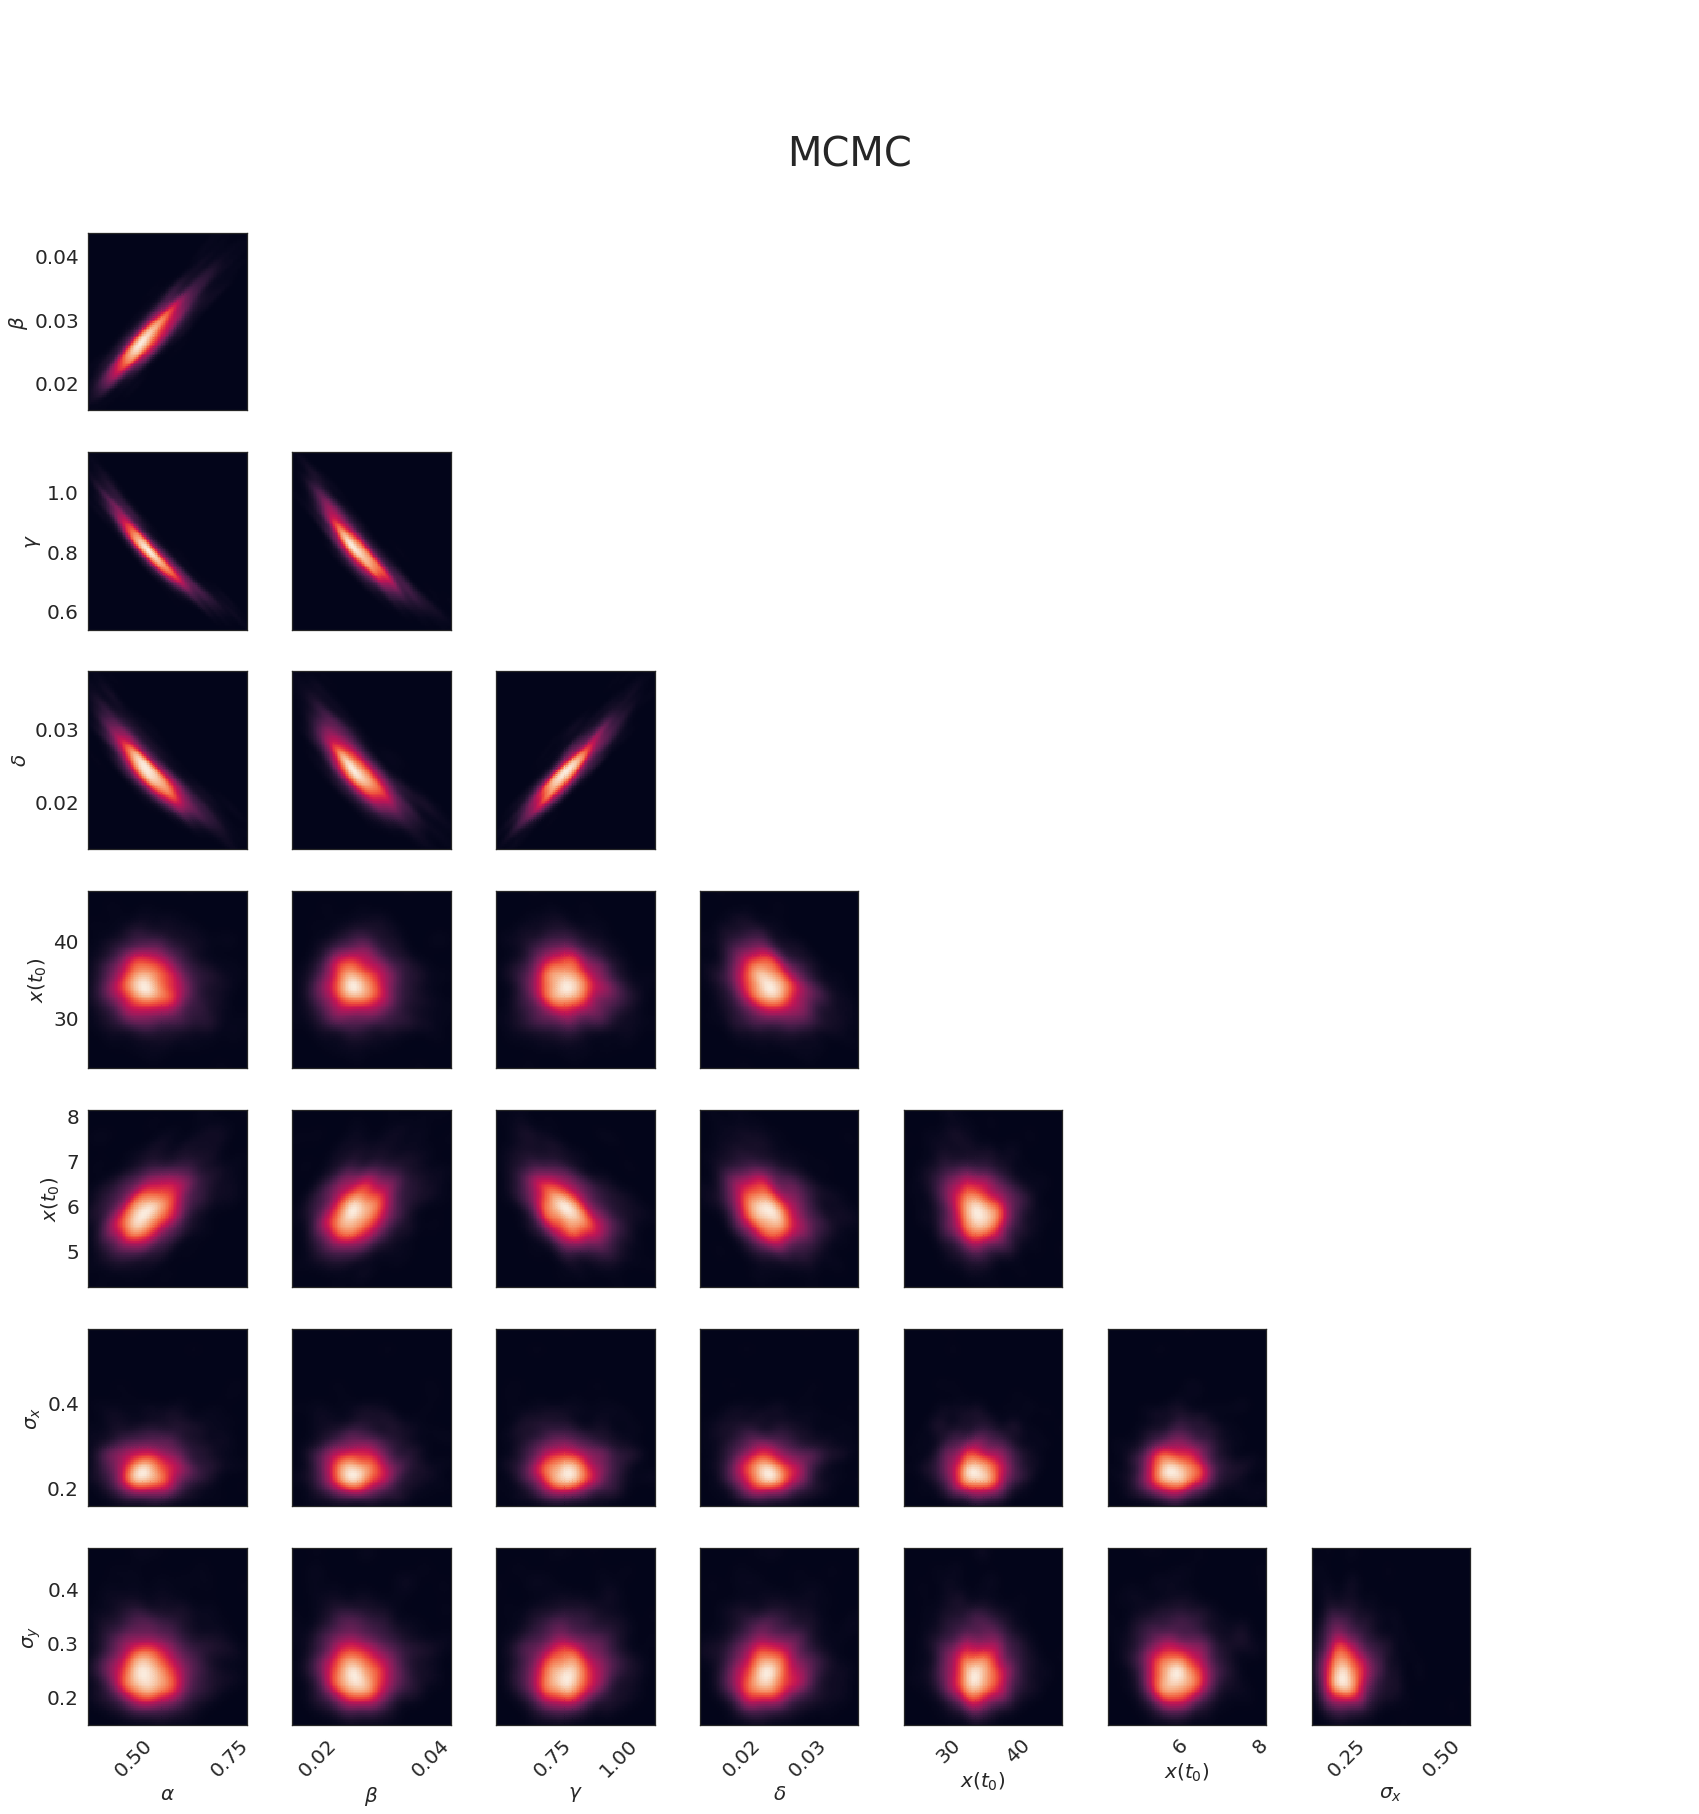

In [12]:
param_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$", 
               r"$x(t_0)$", r"$x(t_0)$",r"$\sigma_x$",r"$\sigma_y$"]
pairwise(mc_params, 'MCMC', param_names);

# Plot the results: Compare Marginals

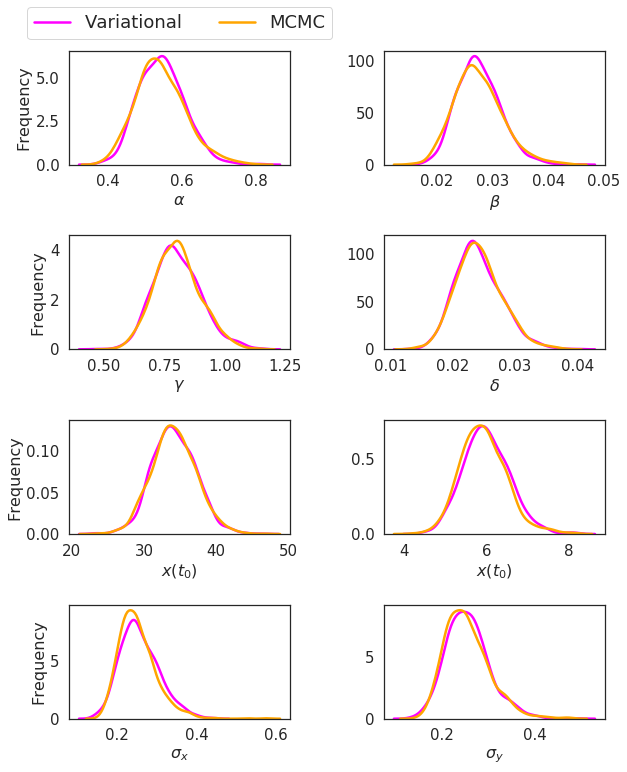

In [13]:
import seaborn as sns
sns.set_context("paper", font_scale=1)
sns.set(rc={"figure.figsize":(9,11),"font.size":16,"axes.titlesize":16,"axes.labelsize":16,
           "xtick.labelsize":15, "ytick.labelsize":15},style="white")

param_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$", 
               r"$x(t_0)$", r"$x(t_0)$",r"$\sigma_x$",r"$\sigma_y$"]

for i, p in enumerate(param_names):
        
        # Add histogram subplot
        plt.subplot(4, 2, i+1)
        
        if i==0:
            sns.kdeplot(vb_params[:, i], color='magenta', linewidth = 2.5, label='Variational')
            sns.kdeplot(mc_params[:, i], color='orange', linewidth = 2.5,label='MCMC')
        else:
            sns.kdeplot(vb_params[:, i], linewidth = 2.5, color='magenta')
            sns.kdeplot(mc_params[:, i], linewidth = 2.5, color='orange')            
        if i%2==0:
            plt.ylabel('Frequency')
        plt.xlabel(param_names[i])        
        if i<1:
            plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower center', ncol=2,fontsize=18)
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()

# Compare joints:

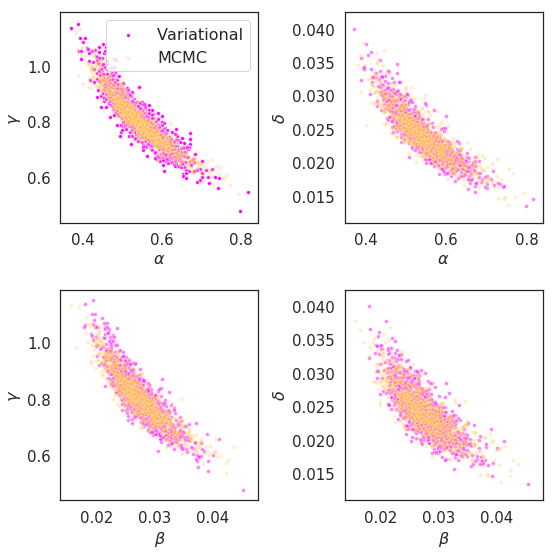

In [14]:
param_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$"]
fig_size = (8, 8)
fig, axes = plt.subplots(2, 2, figsize=fig_size)
for i in range(2):
    for j in range(2):
        if i==0 and j==0:
            sns.scatterplot(vb_params[:, i], vb_params[:, j+2], 
                            ax=axes[i, j], s=15, alpha=1, edgecolors='none',
                            color = 'magenta', label='Variational');
            sns.scatterplot(vb_params[:, i], vb_params[:, j+2], 
                            ax=axes[i, j], s=15, alpha=0.5, edgecolors='none',
                            color = 'magenta');
            sns.scatterplot(mc_params[:, i], mc_params[:, j+2], 
                            ax=axes[i, j], s=15, alpha=0.2, edgecolors='none',
                            color = 'orange', label='MCMC');  
            axes[i,j].legend(fontsize=16)
        else:
            sns.scatterplot(vb_params[:, i], vb_params[:, j+2], 
                        ax=axes[i, j], s=15, alpha=0.5, edgecolors='none', color = 'magenta');
            sns.scatterplot(mc_params[:, i], mc_params[:, j+2], 
                        ax=axes[i, j], s=15, alpha=0.2, edgecolors='none', color = 'orange');
        axes[i,j].set_xlabel(param_names[i])
        axes[i,j].set_ylabel(param_names[j+2])
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()


# Posterior predictives

In [15]:
ppc_samples = pm.sample_posterior_predictive(trace, samples=1000, model=LV_model)['Y_obs']
mean_ppc_mc = ppc_samples.mean(axis=0)
CriL_ppc_mc = np.percentile(ppc_samples,q=2.5,axis=0)
CriU_ppc_mc = np.percentile(ppc_samples,q=97.5,axis=0)

100%|██████████| 1000/1000 [00:10<00:00, 98.32it/s]


In [16]:
ppc_samples = pm.sample_posterior_predictive(trace_vb, samples=1000, model=LV_model)['Y_obs']
mean_ppc_vb = ppc_samples.mean(axis=0)
CriL_ppc_vb = np.percentile(ppc_samples,q=2.5,axis=0)
CriU_ppc_vb = np.percentile(ppc_samples,q=97.5,axis=0)

100%|██████████| 1000/1000 [00:09<00:00, 102.41it/s]


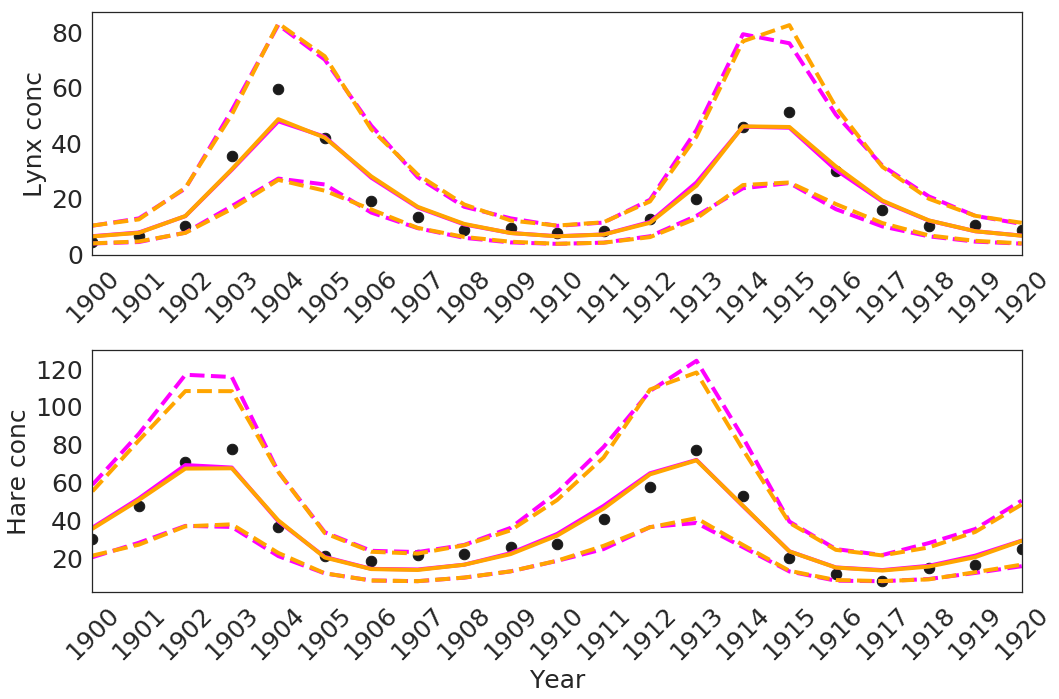

In [17]:
plt.figure(figsize=(15, 10))
plt.subplot(2,1,1)
plt.plot(Year,Lynx,'o', color='k', lw=4, ms=10.5)
plt.plot(Year,mean_ppc_vb[:,1], color='magenta', lw=4)
plt.plot(Year,CriL_ppc_vb[:,1], '--', color='magenta', lw=4)
plt.plot(Year,CriU_ppc_vb[:,1], '--',  color='magenta', lw=4)
plt.plot(Year,mean_ppc_mc[:,1], color='orange', lw=4)
plt.plot(Year,CriL_ppc_mc[:,1], '--', color='orange', lw=4)
plt.plot(Year,CriU_ppc_mc[:,1], '--',  color='orange', lw=4)
plt.xlim([1900,1920])
plt.ylabel('Lynx conc', fontsize=25)
plt.xticks(Year,rotation=45, fontsize=25)
plt.yticks(fontsize=25)
plt.subplot(2,1,2)
plt.plot(Year,Hare,'o', color='k', lw=4, ms=10.5, label='Observed')
plt.plot(Year,mean_ppc_vb[:,0], color='magenta', lw=4, label='Mean Variational')
plt.plot(Year,CriL_ppc_vb[:,0], '--', color='magenta', lw=4, label='Credible Intervals Variational')
plt.plot(Year,CriU_ppc_vb[:,0], '--',  color='magenta', lw=4)
plt.plot(Year,mean_ppc_mc[:,0], color='orange', lw=4, label='Mean MCMC')
plt.plot(Year,CriL_ppc_mc[:,0], '--', color='orange', lw=4, label='Credible Intervals MCMC')
plt.plot(Year,CriU_ppc_mc[:,0], '--',  color='orange', lw=4)
plt.xlim([1900,1920])
plt.xlabel('Year', fontsize=25)
plt.ylabel('Hare conc', fontsize=25)
plt.xticks(Year,rotation=45, fontsize=25)
plt.yticks(fontsize=25)
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()